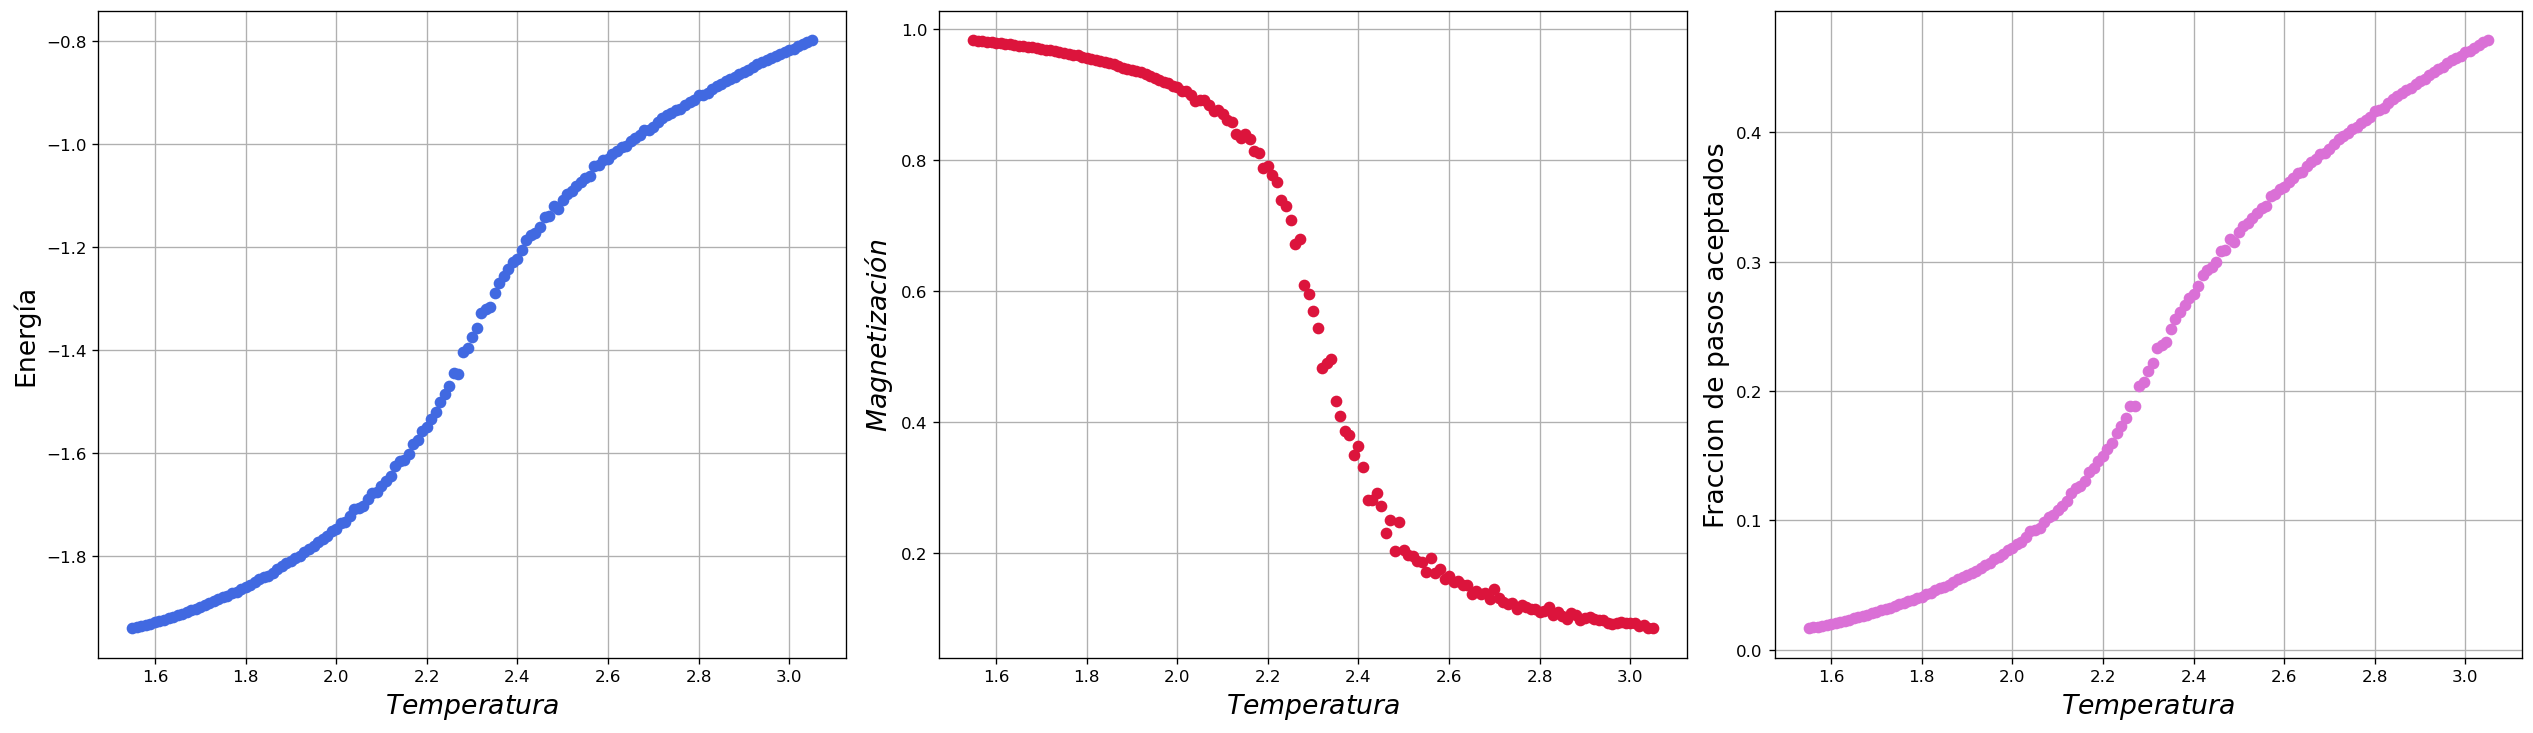

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

results = np.loadtxt("results_vs_T.dat")
temp = results[:,0]
emedia = results[:,2]
mmedia = results[:,1]
chi = results[:,3]
c = results[:,4]
frac_acc = results[:,5]

fig = plt.figure(constrained_layout=True,figsize=(21,6),dpi=120)
gs=fig.add_gridspec(1,3)

ax2=fig.add_subplot(gs[0])
ax2.set_xlabel(r'$Temperatura$',fontsize=16)
ax2.set_ylabel(r'Energía',fontsize=16)
ax2.grid()
ax2.plot(temp,emedia,color='royalblue',marker='o',linestyle='')

ax1=fig.add_subplot(gs[1])
ax1.set_xlabel(r'$Temperatura$',fontsize=16)
ax1.set_ylabel(r'$Magnetización$',fontsize=16)
ax1.grid()
ax1.plot(temp,np.abs(mmedia),color='crimson',marker='o',linestyle='')

ax2=fig.add_subplot(gs[2])
ax2.set_xlabel(r'$Temperatura$',fontsize=16)
ax2.set_ylabel(r'Fraccion de pasos aceptados',fontsize=16)
ax2.grid()
ax2.plot(temp,frac_acc,color='orchid',marker='o',linestyle='')

plt.savefig("/home/anibal-pc/inciso1.png")
# plt.suptitle('Transición de fase',fontsize=20)

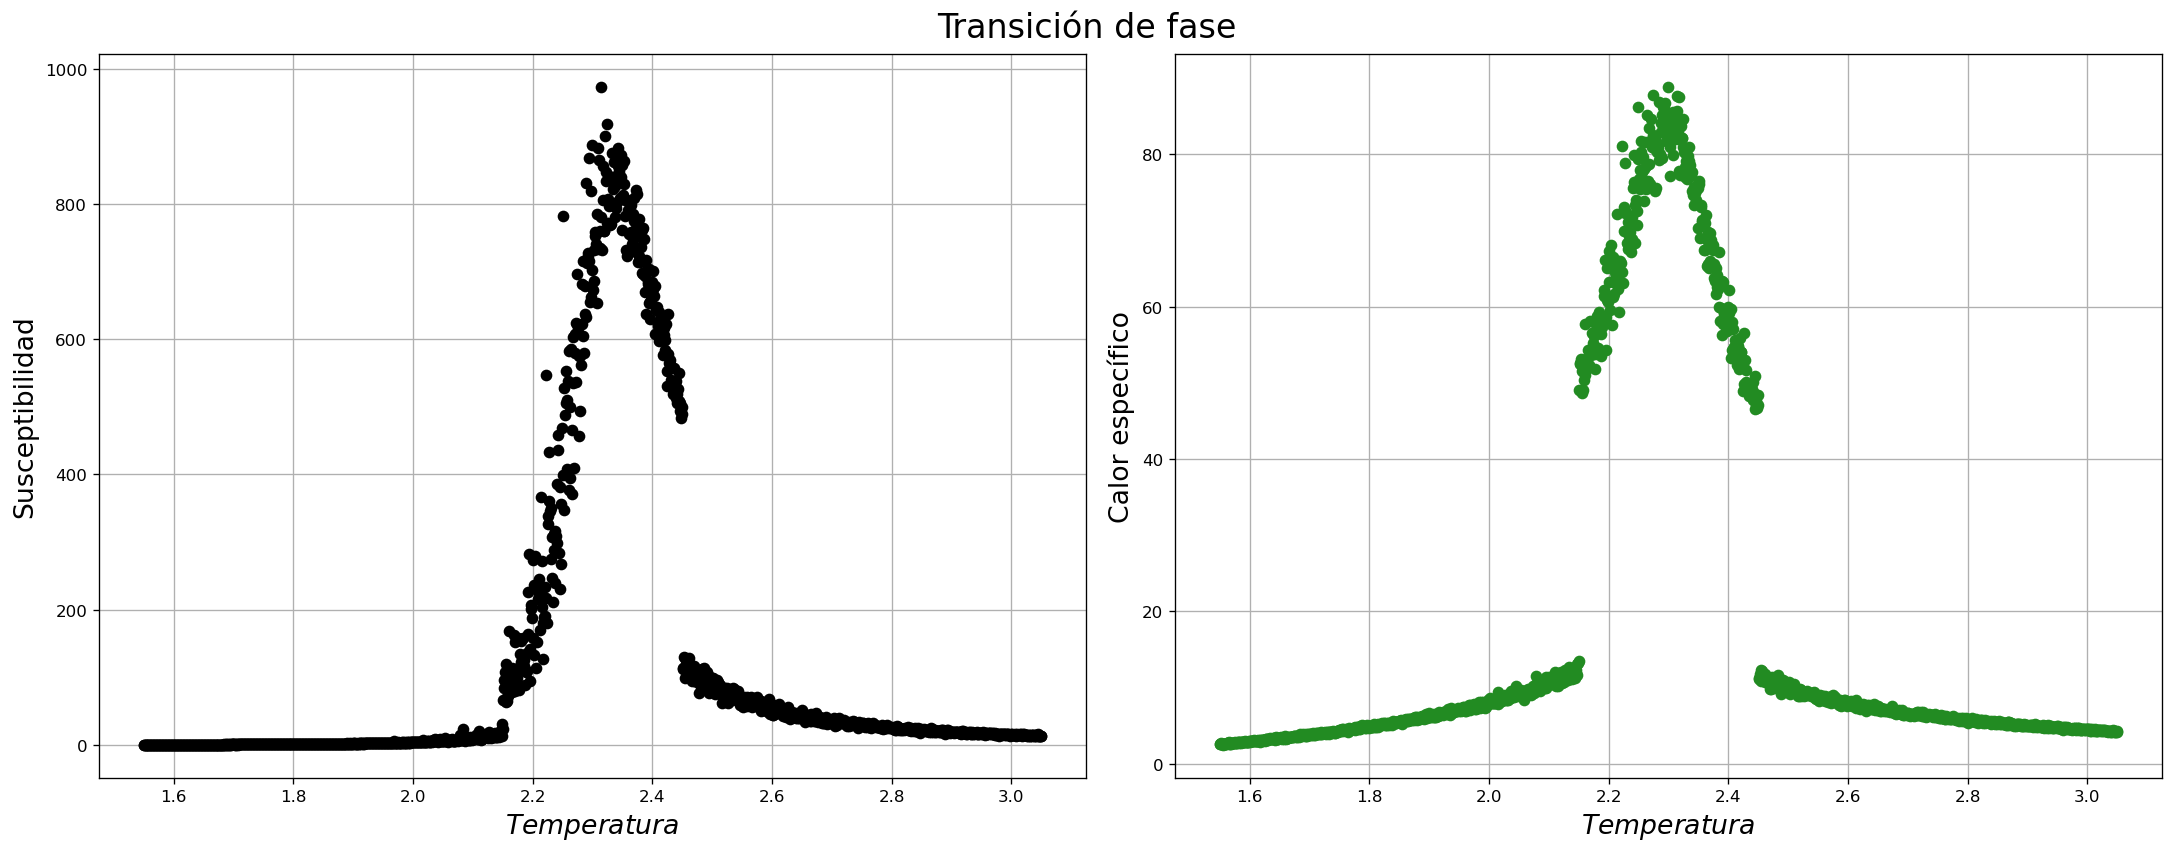

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
results = np.loadtxt("results_vs_T.dat")
temp = results[:,0]
emedia = results[:,2]
mmedia = results[:,1]
chi = results[:,3]
c = results[:,4]
frac_acc = results[:,5]

fig = plt.figure(constrained_layout=True,figsize=(18,7), dpi=120)
gs=fig.add_gridspec(1,2)

ax2=fig.add_subplot(gs[0])
ax2.set_xlabel(r'$Temperatura$',fontsize=16)
ax2.set_ylabel(r'Susceptibilidad',fontsize=16)
ax2.grid()
ax2.plot(temp,np.abs(chi),color='black',marker='o',linestyle='')

ax2=fig.add_subplot(gs[1])
ax2.set_xlabel(r'$Temperatura$',fontsize=16)
ax2.set_ylabel(r'Calor específico',fontsize=16)
ax2.grid()
ax2.plot(temp,c,color='forestgreen',marker='o',linestyle='')

plt.suptitle('Transición de fase',fontsize=20)

plt.savefig("/home/anibal-pc/chi-c.png")

Temperatura critica estimada ≈ 2.31653


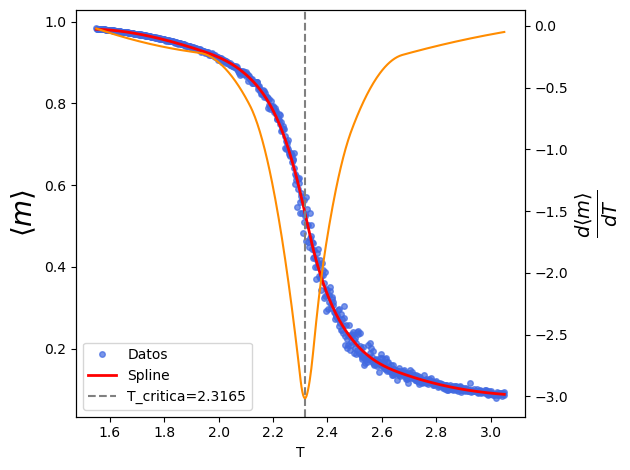

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

results= np.loadtxt("../res_finite_size_effects/results_vs_T30.dat")
T, m = results[:,0], results[:,1]

spline = UnivariateSpline(T, m, s=0.1)

#  Derivada del spline 
dm_dT = spline.derivative()

T_fit = np.linspace(T.min(), T.max(), 500)
m_fit = spline(T_fit)
dm_dT_fit = dm_dT(T_fit)

# --- Ubicar el máximo de |dm/dT| (punto de inflexión) ---
imax = np.argmax(np.abs(dm_dT_fit))
T_inflex = T_fit[imax]
print(f"Temperatura critica estimada ≈ {T_inflex:.5f}")

fig, ax1 = plt.subplots()

color = 'black'
ax1.set_xlabel('T')
ax1.set_ylabel(r'$\langle m \rangle$', color=color, fontsize=20)
ax1.plot(T, m, 'o', ms=4, label='Datos', color='royalblue',alpha=0.7)
ax1.plot(T_fit, m_fit, '-', lw=2, color='red', label='Spline')
ax1.tick_params(axis='y', labelcolor=color)
ax1.axvline(T_inflex, ls='--', color='gray', label=f'T_critica={T_inflex:.4f}')
ax1.legend(loc='lower left')

ax2 = ax1.twinx()
color = 'black'
ax2.set_ylabel(r'$\frac{d\langle m\rangle}{dT}$', color=color,fontsize=20)
ax2.plot(T_fit, dm_dT_fit, '-', lw=1.5, color='darkorange', label='dm/dT')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.savefig("/home/anibal-pc/Tcrit_estim.png")
plt.show()


In [64]:
import numpy as np
from sklearn.linear_model import LinearRegression

def fit_beta_from_M(T, M, Tc, M_err=None, dT_min=0.02, dT_max=0.2, nboot=500, rng=0):
    T = np.asarray(T); M = np.asarray(M)
    dt = Tc - T
    mask = (dt > dT_min) & (dt < dT_max) & (M > 0)
    T_sel, M_sel, dt_sel = T[mask], M[mask], dt[mask]
    if len(T_sel) < 5:
        raise ValueError("Muy pocos puntos en la ventana crítica; ajustá dT_min/dT_max.")
    x = np.log(dt_sel).reshape(-1,1)
    y = np.log(M_sel)
    if M_err is not None:
        w = 1/np.clip(M_err[mask]/M_sel, 1e-12, np.inf)**2  # pesos ~ 1/(σ_y)^2
    else:
        w = np.ones_like(y)

    # Fit central ponderado
    reg = LinearRegression().fit(x, y, sample_weight=w)
    beta_hat = reg.coef_[0]

    # Bootstrap (perturba y con su sigma si hay M_err; si no, re-muestrea)
    rng = np.random.default_rng(rng)
    betas = []
    for _ in range(nboot):
        if M_err is not None:
            yb = y + rng.normal(0, np.mean(M_err[mask]/M_sel))
        else:
            idx = rng.integers(0, len(y), len(y))
            xb, yb, wb = x[idx], y[idx], w[idx]
            regb = LinearRegression().fit(xb, yb, sample_weight=wb)
            betas.append(regb.coef_[0]); continue
        regb = LinearRegression().fit(x, yb, sample_weight=w)
        betas.append(regb.coef_[0])
    betas = np.array(betas)
    lo, hi = np.percentile(betas, [16,84])
    return beta_hat, (lo, hi)


fit_beta_from_M(T, m, 2.3165)

(0.18052901732398224, (0.1736535180282916, 0.187014455258483))

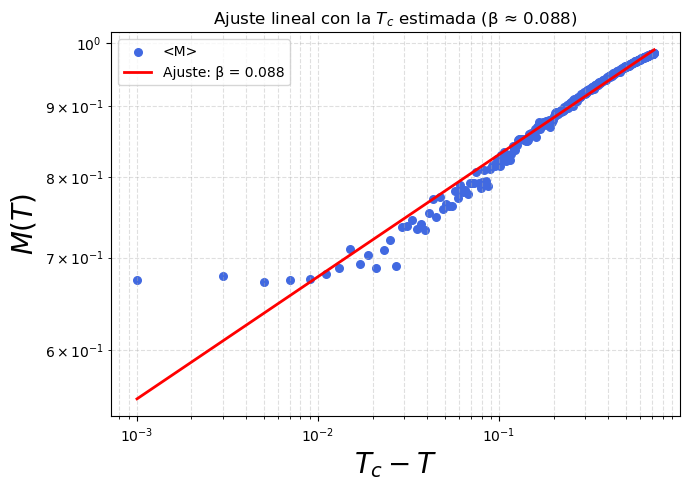

In [71]:

Tc = 2.269

mask = (T < Tc) & (m > 0)
T_sel = T[mask]
m_sel = m[mask]

x = Tc - T_sel

logx = np.log(x)
logm = np.log(m_sel)

coef = np.polyfit(logx, logm, 1)
beta_fit = coef[0]
A_fit = np.exp(coef[1])

x_fit = np.linspace(x.min(), x.max(), 200)
m_fit = A_fit * x_fit**beta_fit

plt.figure(figsize=(7,5))
plt.scatter(x, m_sel, color='royalblue', label='<M>', s=30)
plt.plot(x_fit, m_fit, 'r-', lw=2, label=f'Ajuste: β = {beta_fit:.3f}')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$T_c - T$',fontsize=20)
plt.ylabel(r'$M(T)$',fontsize=20)
plt.title(f'Ajuste lineal con la $T_c$ estimada (β ≈ {beta_fit:.3f})')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.tight_layout()
plt.savefig('/home/anibal-pc/fitbeta.png')
plt.show()


In [72]:
0.088/(1/2)

0.176

/tmp/ipykernel_44843/3732759028.py:10: RuntimeWarning: divide by zero encountered in divide
  chi1 = 1/(2*(T_c - T1))
/tmp/ipykernel_44843/3732759028.py:11: RuntimeWarning: divide by zero encountered in divide
  chi2 = 1/(T2-T_c)
/tmp/ipykernel_44843/3732759028.py:35: RuntimeWarning: divide by zero encountered in divide
  l2=1/(1-L2)


Text(0.5, 0.98, 'Campo medio')

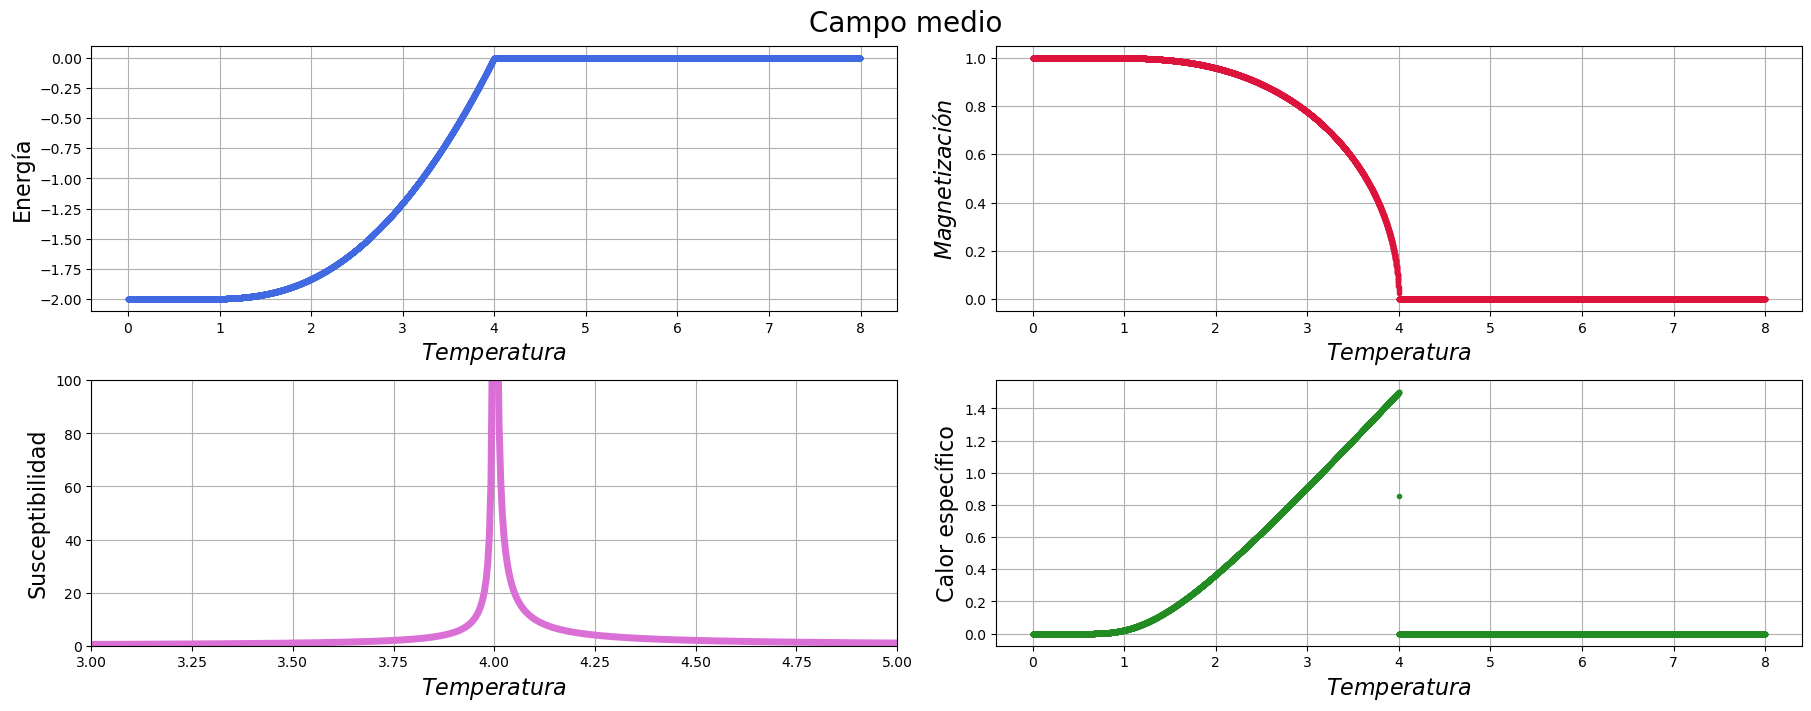

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton
#--------------------------------------------------------------------
#Graficamos la suceptibilidad
T_c = 4    #para una red de Ising 2D Tc=4*J/Kb
cero=10**(-8)
T1=np.linspace(cero,T_c,1000)
T2=np.linspace(T_c,8,1000)
chi1 = 1/(2*(T_c - T1))
chi2 = 1/(T2-T_c)

#--------------------------------------------------------------------
#resuelve la ecuacion de autoconsistencia usando el metodo de Newton
# Definimos la función a la que le queremos buscar los ceros
def f(x):
    return x - np.tanh(beta*q*J*x)

    # Definimos parámetros para el sistema
q   = 4   # Número de primeros vecinos
J   = 1   # Energía de interacción entre primeros vecinos
kTc = q*J # Temperatura crítica
# Calculamos los ceros de la función entre kT=0 y kT=2*kTc. Generamos un vector con temperaturas en este rango.
kT = np.arange(.0001*2*kTc, 2*kTc, .0001*2*kTc)
L0 = np.zeros(np.size(kT))

# Usamos el método de la secante para encontrar los ceros para cada temperatura
x = 1.1 # Guess inicial
for i in range(np.size(kT)):
    beta = 1./kT[i]
    L0[i] = newton(f, x, tol=1e-08, maxiter=100)
#--------------------------------------------------------------------
#Calor especifico
L2=L0**2
l2=1/(1-L2)
tt=kT/kTc
tt2=tt**2
c=L2/((tt2)*(l2)-tt)
#--------------------------------------------------------------------
fig = plt.figure(constrained_layout=True,figsize=(18,7))
gs=fig.add_gridspec(2,2)

ax2=fig.add_subplot(gs[0,0])
ax2.set_xlabel(r'$Temperatura$',fontsize=16)
ax2.set_ylabel(r'Energía',fontsize=16)
ax2.grid()
# plt.axvspan(0,4,color='blue', alpha = 0.20)
ax2.plot(kT,-2*np.abs(L0)**2,color='royalblue',marker='.',linestyle='')

ax1=fig.add_subplot(gs[0,1])
ax1.set_xlabel(r'$Temperatura$',fontsize=16)
ax1.set_ylabel(r'$Magnetización$',fontsize=16)
ax1.grid()
# plt.axvspan(0,4,color='blue', alpha = 0.20)
ax1.plot(kT,L0,color='crimson',marker='.',linestyle='')

ax2=fig.add_subplot(gs[1,0])
plt.xlim(3,5)
plt.ylim(0,100)
ax2.set_xlabel(r'$Temperatura$',fontsize=16)
ax2.set_ylabel(r'Susceptibilidad',fontsize=16)
ax2.grid()
# plt.axvspan(0,4,color='blue', alpha = 0.20)
ax2.plot(T2,chi2,color='orchid',marker='',linestyle='-',lw='5')
ax2.plot(T1,chi1,color='orchid',marker='',linestyle='-',lw='5')

ax2=fig.add_subplot(gs[1,1])

ax2.set_xlabel(r'$Temperatura$',fontsize=16)
ax2.set_ylabel(r'Calor específico',fontsize=16)
ax2.grid()
# plt.axvspan(0,4,color='blue', alpha = 0.20)
ax2.plot(kT,c,color='forestgreen',marker='.',linestyle='')

plt.suptitle('Campo medio',fontsize=20)